In [101]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import math

In [5]:
def doMesh(zeta, xmin, dx, mesh):
	"""
  	Initialize radial grid 
	"""
	x   = np.zeros(mesh)
	for i in range(mesh):
		x[i] = xmin + i * dx
	
	r   = np.exp(x) / zeta
	sqr = np.sqrt(r) 
	r2  = r**2 

	# Printing information about grid paramters 
	print("Radial grid information:")
	print("dx = %10.6f, xmin = %10.6f, zmesh = %10.6f" % (dx, xmin, zeta))
	print("mesh = %6i, r(0) = %10.6f, r(mesh) = %10.6f" % (mesh, r[0], r[-1]) )

	return r, sqr, r2

In [273]:
def initPot(zeta, r, mesh):
	"""
	Initialize potential
	"""
	# In this problem Coloumb potential is considered
	# Note factor 2.0 due to atomic units with Ry
	#vpot = -2.0 * zeta / r 
	vpot = -2.0 * zeta * np.exp(-0.05 * r) / r 

	return vpot

In [1]:
def solveSE(n, l, mesh, dx, r, sqr, r2, vpot, zeta):
	""" 
    Solve the schroedinger equation in radial coordinates on a 
	logarithmic grid by Numerov method - atomic (Ry) units
	"""
	# Set maximum number of iterations 
	maxIter = 100

	# Set tolerance for eigenvalue
	tolerance = 1E-8

	# Set the cetrifugal part of the potential
	centrifug = (l + 0.5)**2

	# Nodes number
	nodes = n - l - 1 

	# Set deltaX**2 / 12
	ddx12 = dx**2 / 12.0

	# Set (very rough) initial lower and upper bounds to the eigenvalue
	eUp  = vpot[mesh-1]
	eLow = min(vpot + centrifug / r2)
	 
	assertMsg = 'SolveSE: lower and upper bounds are equal. eUp = %10.6f, eLow = %10.6f' % (eUp, eLow) 
	assert eUp - eLow > tolerance, assertMsg 

	e = 0.5 * (eUp + eLow)

	# Print header 
	print ("Iter\te\t\teLow\t\teUp\t\t    de\t\tncross  nodes")
	numIter = 0
	while numIter <= maxIter:
		if numIter >= 1:
			print ("%3i\t%8.5f\t%8.5f\t%8.5f\t%8.2f\t%1i\t%1i" % (numIter, e, eLow, eUp, de, ncross, nodes))
		de = 0.0
		numIter += 1
    	# Set up the g-function and determine the position of its last
	    # change of sign
		# g < 0 (approximately) means classically allowed   region
		# g > 0         "         "        "      forbidden   "
		g = ddx12 * (r2 * (e - vpot) - centrifug)
		# Initialize turn point index
		icl = -1
		for i in range(1, mesh):
			# Beware: if f(i) is exactly zero the change of sign is not observed
			# the following line is a trick to prevent missing a change of sign 
			# in this unlikely but not impossible case:
			if g[i] == 0.0: g[i] == 1E-10
			if g[i] * g[i-1] < 0: icl = i  

		if icl < 0 or icl >= mesh-2:
	    	# classical turning point not found or too far away
		    # no panic: it may follow from a bad choice of eup in
			# the first iterations. Update e and eUp and re-try
			eUp = e
			e = 0.5 * (eUp + eLow)
			continue

		# Fucntion f required by Numerov method
		f = 1.0 + g 
		# Initilize y
		y = np.zeros(mesh)
		# Determination of the wave-function in the first two points 
	    # Asymptotic behaviour - second term depends upon the potential)
		y[0] = r[0]**(l+1) * ( 1.0 - 2.0 * zeta * r[0] / (2 * l + 2) ) / sqr[0]
		y[1] = r[1]**(l+1) * ( 1.0 - 2.0 * zeta * r[1] / (2 * l + 2) ) / sqr[1]
		# Outward integration, count number of crossings
		ncross = 0
		for i in range(1, icl):
			y[i+1] = ( (12.0 - 10.0 * f[i]) * y[i] - f[i-1] * y[i-1] ) / f[i+1]
			if y[i+1] == 0: y[i+1] = 1E-20
			if y[i] * y[i+1] < 0: ncross += 1

		fac = y[icl]	
		# Check number of crossings
		if ncross !=  nodes:
			if ncross > nodes:
				eUp = e
			else:
				eLow = e
			e = 0.5 * (eUp + eLow)
			continue

		# Determination of the wave-function in the last two points 
	    # Assuming y[mesh] = 0 and y[mesh-1] = dx
		y[mesh-1] = dx
		y[mesh-2] = (12.0 - 10.0 * f[mesh-1]) * y[mesh-1] / f[mesh-2]
	    # Inward integration 
		for i in range(icl+1, mesh-2)[::-1]:
			y[i-1] = ( (12.0 - 10.0 * f[i]) * y[i] - f[i+1] * y[i+1] ) / f[i-1]
			if abs(y[i-1]) > 1E20:
				y[i-1:] /= y[i-1]

		# Rescale function 
		fac = fac / y[icl]
		y[icl:] = fac * y[icl:]

		# Normalization. Note the change of the variable:
		# \int f(r) dr => \sum_i f_i r_i dx
		norm = 0.0
		for i in range(mesh):
			norm += y[i] * y[i] * r2[i] * dx

		y = y / np.sqrt(norm)
	
		# Find the value of the cusp at the turning point (icl)
		i = icl
		ycusp = (y[i-1] * f[i-1] + y[i+1] * f[i+1] + 10.0 * y[i] * f[i]) / 12.0
		dfcusp = f[i] * (y[i] / ycusp - 1.0) 

		# eigenvalue update using pertubation theory
		de = dfcusp/ddx12 * ycusp**2  * dx
		if (de > 0.0): eLow = e
		if (de < 0.0): eUp  = e

	  	# Prevent e to go out of bounds, i.e. e > eup or e < elw 
		# (might happen far from convergence)
		e = max(min(e+de,eUp),eLow)
		# Convergence check
		if abs(de) < tolerance: break
	
	# Was convergence achived?
	if (abs(de) > tolerance):
		if ncross != nodes:
			print (e, eLow, eUp, ncross, nodes, icl)
		else:
			print (e, de)
		print("Erro in solveSE: too many iterations")
	# Convergence has bee achived
	else:
		print("Convergence achieved at iter #%3i, de = %10.4e)" % (numIter, de))
	
	return y, e


In [8]:
def printWF(filename, r, sqr, y, e):
	"""
	Print radial part of the wave function
	"""
	f = open(filename, 'w')
	f.write("\t r\t\t\t\t R(r)\t\t\t X(r)=rR(r)\t\te\n")
	f.write(80*"-")
	f.write("\n")
	for i in range(len(y)):
		f.write( "%15.8f\t%15.8f\t%15.8f\t%15.8f\n" % (r[i], y[i] / sqr[i], y[i] * sqr[i], e) )

	f.close()

In [264]:
def hydrogen():
	"""
	Find a solution with given N, L for an hydrogenic atom
	solving the radial schroedinger equation by Numerov method
	Atomic (Ry) units """ 
	while True:
		try:
			zeta = float(input("Atomic Charge > "))
		except ValueError:
			print ("Please type a number >= 1 or -1 to exit" )
			continue

		if zeta == -1:
			sys.exit()
		elif zeta < 1:
			print ("Zeta should be >= 1")
		else:
			break

  	#Initialize logarithmic mesh
	rmax = 100.0
	xmin = -8.0
	dx = 0.01 

	#Number of points in the mesh
	mesh = int((np.log(zeta * rmax) - xmin) / dx)

	#Initialize radial mesh	
	r, sqr, r2 = doMesh(zeta=zeta, xmin=xmin, dx=dx, mesh=mesh)

	#Initialize potential	
	vpot = initPot(zeta=zeta, r=r, mesh=mesh)

	while True:
		try:
			print
			nl = input("n, l >> ")	
			if nl == '-1': sys.exit()
			n, l = nl.split(' ')
			n = int(n)
			l = int(l)
		except ValueError:
			print ("Please type two integer numbers n and l separated by space or type -1 to exit")  
			continue

		if n < 1:
			print ("n should be >= 1. Try again or type -1 to exit")
		elif n < l+1:
			print ("n < l + 1: wrong number of nodes. Try again or type -1 to exit")
		elif l < 0:
			print ("l < 0 unphysical value. Try again or type -1 to exit")
		else:
			y, e = solveSE(n=n, l=l, mesh=mesh, dx=dx, r=r, sqr=sqr, r2=r2, vpot=vpot, zeta=zeta)   
			print ("eigenvalue = %15.8f, eig*(n/zeta)^2 = %15.8f" % (e, e*(n/zeta)**2))
			printWF('wfc_yukawa_'+str(n)+'_'+str(l)+'.out', r=r, sqr=sqr, y=y, e=e)
#			break

In [286]:
hydrogen()

Atomic Charge > -1


SystemExit: 

## 1. Examine solutions as a function of n and l; verify the presence of accidental degeneracy.

In [86]:
e = [[] for i in range(5)]
for n in range(1, 6):
    for l in range(n):
        with open('wfc_'+str(n)+'_'+str(l)+'.out') as f:
            for i, line in enumerate(f):
                if i > 1:
                    e[n-1].append(round(float(line.split()[3]), 5))
                    break

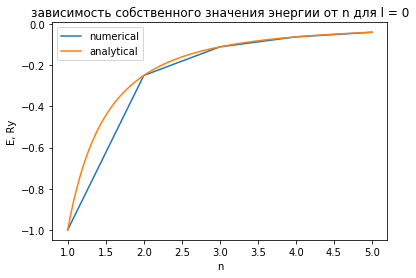

In [87]:
e1 = [e[i][0] for i in range(len(e))]
plt.plot(np.arange(1, 6), e1, label = 'numerical')
a = np.linspace(1, 5, 100)
plt.plot(a, np.multiply(np.power(a, -2), -1), label = 'analytical')
plt.title('зависимость собственного значения энергии от n для l = 0')
plt.xlabel('n')
plt.ylabel('E, Ry')
plt.legend()

No handles with labels found to put in legend.


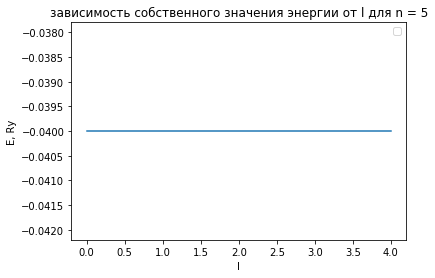

In [88]:
e1 = [e[4][i] for i in range(len(e[4]))]
plt.plot(np.arange(0, 5), e1)
plt.title('зависимость собственного значения энергии от l для n = 5')
plt.xlabel('l')
plt.ylabel('E, Ry')
plt.legend()

Вот и потверждение вырождения. 

## 2. Examine solutions as a function of the nuclear charge Z.

In [89]:
e = []
for z in range(1, 6):
    with open('wfc__'+str(z)+'.0.out') as f:
        for i, line in enumerate(f):
            if i > 1:
                e.append(round(float(line.split()[3]), 5))
                break

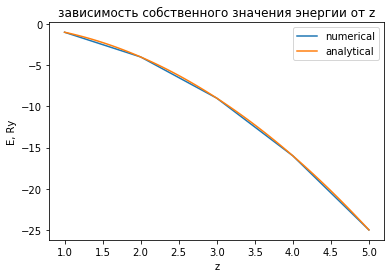

In [93]:
plt.plot(np.arange(1, 6), e, label = 'numerical')
a = np.linspace(1, 5, 100)
plt.plot(a, np.multiply(np.power(a, 2), -1), label = 'analytical')
plt.title('зависимость собственного значения энергии от z')
plt.xlabel('z')
plt.ylabel('E, Ry')
plt.legend()

## 3. Compare the numerical solution with the exact solution, Eq.(2.29), for the 1s case (or other cases if you know the analytic solution).

In [157]:
r, R, xi = [], [], []
with open('wfc.out') as f:
    for i, line in enumerate(f):
        if i > 1:
            r.append(float(line.split()[0]))
            R.append(float(line.split()[1]))
            xi.append(float(line.split()[2]))

In [172]:
def psi(r):
    return(math.exp(-r))

In [203]:
def norm(psi):
    s = 0
    for i in range(len(psi)-1):
        s += ((r[i+1]+r[i])/2)**2*psi[i]**2*(r[i+1]-r[i])
    return([psi[i]/s**0.5 for i in range(len(psi))])

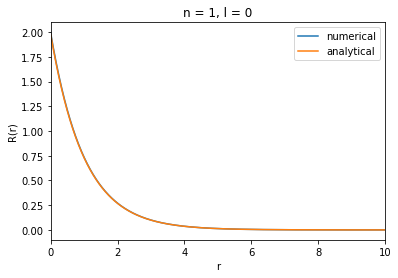

In [212]:
plt.plot(r, R, label = 'numerical')
psy_1 = [psi(r[i]) for i in range(len(r))]
psy = norm(psy_1)
plt.plot(r, psy, label = 'analytical')
plt.xlabel('r')
plt.ylabel('R(r)')
plt.title('n = 1, l = 0')
plt.xlim(0, 10)
plt.legend()

Text(0, 0.5, '$\\delta$R/R')

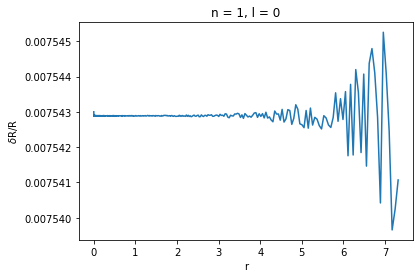

In [263]:
plt.figure()
diff = [(R[i]-psy[i])/psy[i] for i in range(1000)]
plt.plot(r[:1000], diff[:])
plt.title('n = 1, l = 0')
plt.xlabel('r')
plt.ylabel('$\delta$R/R')

Относительная ошибка начинает флуктуировать в больших пределах при увеличении r.

## 5. Calculate the expectation values of r and of 1/r, compare them with the known analytical results.

In [131]:
r1, r2, s = 0, 0, 0
for i in range(len(r)-1):
    r1 += r[i]**3*(r[i+1]-r[i])*R[i]**2
    r2 += r[i]*(r[i+1]-r[i])*R[i]**2
    s += r[i]**2*(r[i+1]-r[i])*R[i]**2
print('Numerical r, 1/r:', r1/s, ',', r2/s)
print('Analytical r, 1/r:', 1.5, ',', 1)
print('все супер :)')

Numerical r, 1/r: 1.5000000020726614 , 0.9999997767615807
Analytical r, 1/r: 1.5 , 1
все супер :)


## 4. Slightly modify the potential as defined in subroutine init pot, verify that the accidental degeneracy disappears. Some suggestions: exponential damping (Yukawa) $V (r) = -Zq_e^2exp(-Qr)/r$, where Q is a number of the order of 0.05 a.u..

In [276]:
e = []
n = 3
for l in range(n):
    with open('wfc_yukawa_'+str(n)+'_'+str(l)+'.out') as f:
        for i, line in enumerate(f):
            if i > 1:
                e.append(round(float(line.split()[3]), 5))
                break

No handles with labels found to put in legend.


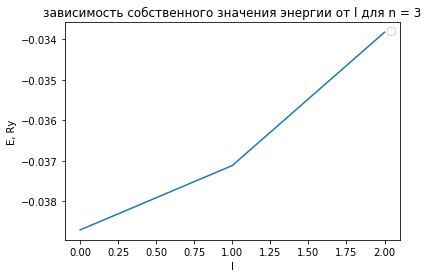

In [277]:
plt.plot(np.arange(0, 3), e)
plt.title('зависимость собственного значения энергии от l для n = 3')
plt.xlabel('l')
plt.ylabel('E, Ry')
plt.legend()

Энергия зависит от l, а не константа, как при начальном потенциале. Вырождение снялось.

Картинки для поднятия настроения и первого-второго заданий. 

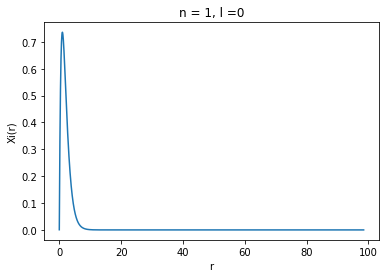

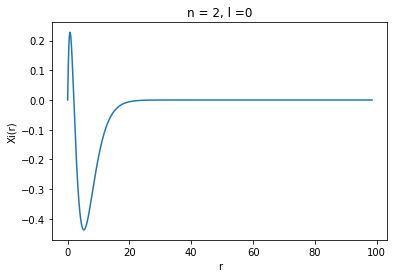

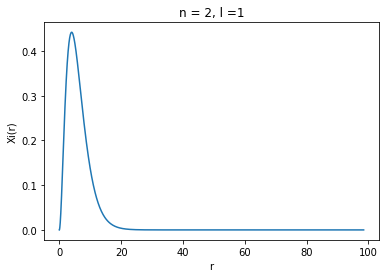

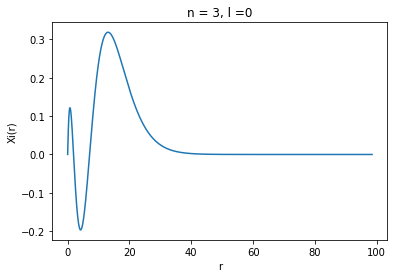

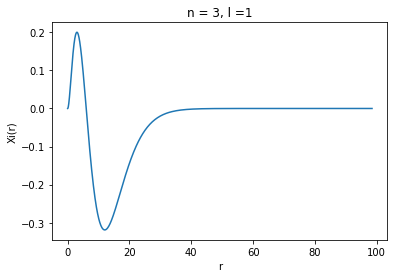

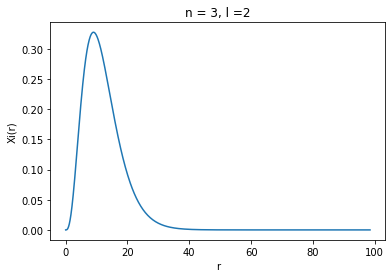

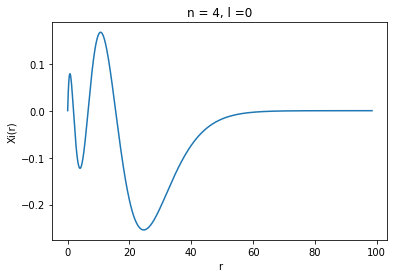

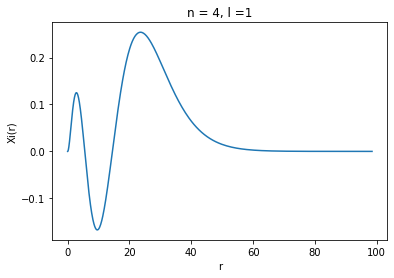

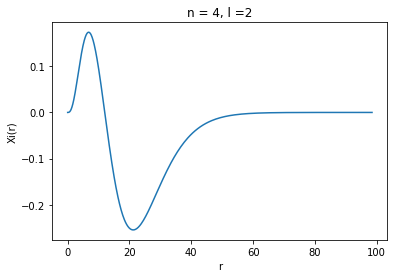

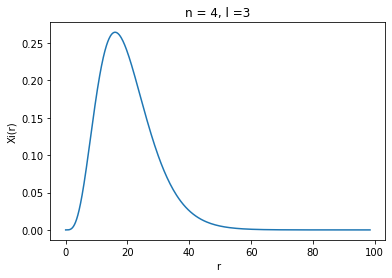

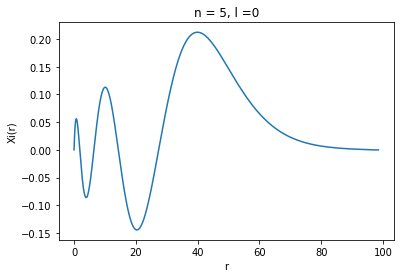

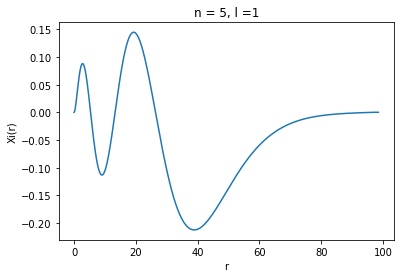

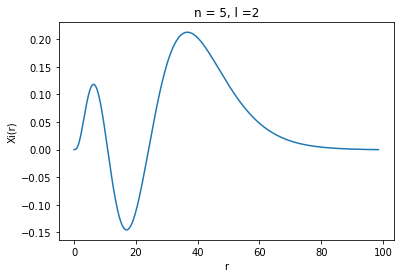

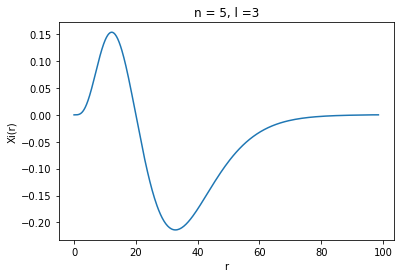

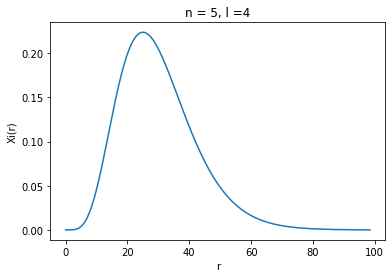

In [280]:
for n in range(1, 6):
    for l in range(n):
        r, R, xi = [], [], []
        with open('wfc_'+str(n)+'_'+str(l)+'.out') as f:
            for i, line in enumerate(f):
                if i > 1:
                    r.append(float(line.split()[0]))
                    R.append(float(line.split()[1]))
                    xi.append(float(line.split()[2]))
        plt.figure()
        plt.plot(r, xi)
        plt.title('n = '+str(n)+', l ='+str(l))
        plt.xlabel('r')
        plt.ylabel('Xi(r)')

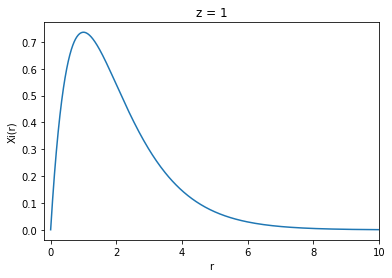

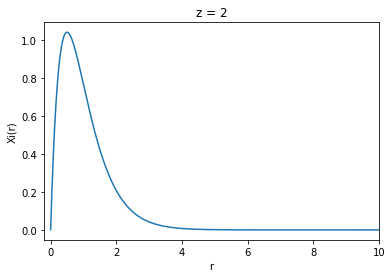

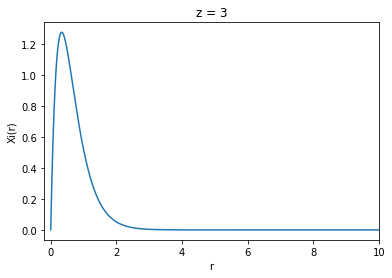

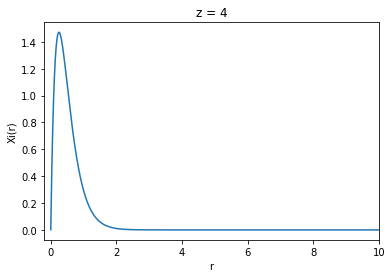

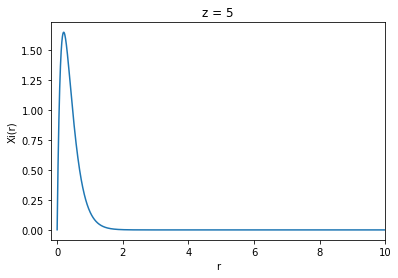

In [288]:
for z in range(1, 6):
    r, R, xi = [], [], []
    with open('wfc__'+str(z)+'.0.out') as f:
        for i, line in enumerate(f):
            if i > 1:
                r.append(float(line.split()[0]))
                R.append(float(line.split()[1]))
                xi.append(float(line.split()[2]))
    plt.figure()
    plt.plot(r, xi)
    plt.title('z = '+str(z))
    plt.xlabel('r')
    plt.ylabel('Xi(r)')
    plt.xlim(-0.2, 10)